# External Data assimilation with the WOFOST model: EnKF filter

**Credit:** Jose Gómez-Dans (NCEO & UCL)  `j.gomez-dans@ucl.ac.uk`

In [19]:
%matplotlib inline
import sys, os
import copy
from pathlib import Path
import datetime as dt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import matplotlib

from pcse.fileinput import CABOFileReader, YAMLCropDataProvider, CABOWeatherDataProvider,YAMLAgroManagementReader, ExcelWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.models import Wofost71_WLP_FD, Wofost71_PP

import ipywidgets.widgets as widgets
from ipywidgets import interact, interactive, fixed


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/tmp/ipykernel_7157/585724010.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
data_dir = os.path.join(os.getcwd(), "data")

agromanagement_contents = """
Version: 1.0
AgroManagement:
- {year:d}-01-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: '{variety}'
        crop_start_date: {crop_start_date}
        crop_start_type: sowing
        crop_end_date: {crop_end_date}
        crop_end_type: harvest
        max_duration: 150
    TimedEvents: null
    StateEvents: null
"""
WOFOST_PARAMETERS = ['DVS', 'LAI', 'TAGP', 'TWSO', 'TWLV', 'TWST',
                'TWRT', 'TRA', 'RD', 'SM']
LABELS = ["Development stage [-]", "LAI [m2/m2]",
                 "Total Biomass [kg/ha]",
                 "Total Storage Organ Weight [kg/ha]",
                 "Total Leaves Weight [kg/ha]",
                 "Total Stems Weight [kg/ha]",
                 "Total Root Weight [kg/ha]",
                 "Transpiration rate [cm/d]",
                 "Rooting depth [cm]",
                 "Soil moisture [cm3/cm3]"]
WOFOST_LABELS = dict(zip(WOFOST_PARAMETERS, LABELS))

In [9]:
def set_wofost_up(crop="soybean", variety="Soybean_901", 
                soil="M04.AWC", wav=10, co2=360, rdmsol=100):
    meteofile="chwele.xls"
    cropdata = YAMLCropDataProvider(os.path.join(data_dir, "crop"))
    cropdata.set_active_crop(crop, variety)
    soilfile = os.path.join(data_dir, 'soil', soil)
    soildata = CABOFileReader(soilfile)
    soildata["RDMSOL"] = rdmsol
    sitedata = WOFOST71SiteDataProvider(WAV=wav, CO2=co2)
    parameters = ParameterProvider(cropdata=cropdata,
                                   soildata=soildata, sitedata=sitedata)

    agromanagement_file = os.path.join(data_dir, 'agro', 'lintul3_soybeans_calendar.agro')
    agromanagement = YAMLAgroManagementReader(agromanagement_file)

    meteo = os.path.join(data_dir, 'meteo', meteofile)
    wdp = ExcelWeatherDataProvider(meteo)
    return parameters, agromanagement, wdp

def run_wofost(parameters, agromanagement, wdp, potential=False):
    if potential:
        wofsim = Wofost71_PP(parameters, wdp, agromanagement)
    else:        
        wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
    print(parameters)
    wofsim.run_till_terminate()
    df_results = pd.DataFrame(wofsim.get_output())
    df_results = df_results.set_index("day")
    return df_results, wofsim

In [15]:
#parameters, agromanagement, wdp = set_wofost_up()
#df_results, wofsim = run_wofost(parameters, agromanagement, wdp, potential=False)
#df_results

In [11]:
def prepare_observations(start_date=dt.date(2020, 9, 15),
                         end_date=dt.date(2021, 1, 12),
                        obs_file="data/sample_wofost_output.csv",
                        n_obs=7, sigma_lai=0.1, sigma_sm=0.25):

    df = pd.read_csv(obs_file)
    df['date'] = pd.to_datetime(df.day)
    df.set_index('date')
    df = df[(df.date >= start_date) &
            (df.date <= end_date)]
    lai_obs = df.LAI.values
    sm_obs = df.SM.values
    obs_times = df.date.values
    obs_passer = np.arange(len(obs_times))
    np.random.shuffle(obs_passer)
    observations = []

    # Pack them into a convenient format
    for i, (datex, lai, sm) in enumerate(zip(obs_times[obs_passer], lai_obs[obs_passer],
                                       sm_obs[obs_passer])):
        if ~np.isnan(lai) and ~np.isnan(sm):
            lai_unc = lai*sigma_lai
            sm_unc = sm * sigma_sm
            dd = datex.astype('datetime64[s]').tolist()
            observations.append((dd,
            {"LAI": (lai, lai_unc), "SM": (sm, sm_unc)}))
    observations = observations[:n_obs]

    observations = sorted(observations, key=lambda x: x[0])
    return observations

In [12]:
class WOFOSTEnKF(object):
    def __init__(self, assimilation_variables, override_parameters,
                n_ensemble, observations,
                lai_unc=0.1, sm_unc=0.25):
        self.n_ensemble = n_ensemble
        self.assimilation_variables = assimilation_variables
        self.override_parameters = override_parameters
        self.lai_unc = lai_unc
        self.sm_unc = sm_unc
        self.observations = observations

    def setup_wofost(self, crop="soybean", variety="Soybean_901",soil="M04.AWC", wav=10,
                     co2=360, rdmsol=100):
        self.parameters, self.agromanagement, self.weather_db = set_wofost_up(
            crop=crop, variety=variety, 
            soil=soil, wav=wav, co2=co2, rdmsol=rdmsol)
        self._setup_ensemble()

    def _setup_ensemble(self):
        self.ensemble = []
        for i in range(self.n_ensemble):
            p = copy.deepcopy(self.parameters)
            for par, distr in self.override_parameters.items():
                p.set_override(par, distr[i])
            member = Wofost71_WLP_FD(p, self.weather_db, self.agromanagement)
            self.ensemble.append(member)

    def run_filter(self):
        if len(self.assimilation_variables) > 0:
            for obs_date, obs in tqdm(self.observations):
                
                ensemble_state = self._run_wofost_gather_sates(obs_date)
                P = np.array(ensemble_state.cov().values)
                ensemble_obs = self._observations_ensemble(obs)
                R = np.array(ensemble_obs.cov().values)
                xx = [obs[x] for x in self.assimilation_variables]
                obs = xx
                K = self.kalman_gain(obs, P, R)
                x = np.array(ensemble_state.values).T
                y = np.array(ensemble_obs.values).T
                x_opt = x + K @ (y - x)
                df_analysis = pd.DataFrame(x_opt.T,
                    columns=self.assimilation_variables)
                for member, new_states in zip(self.ensemble,
                                            df_analysis.itertuples()):
                    if "LAI" in self.assimilation_variables:
                        member.set_variable("LAI", new_states.LAI)
                    if "SM" in self.assimilation_variables:
                        member.set_variable("SM", new_states.SM)

        [member.run_till_terminate() for member in self.ensemble]

        results = [pd.DataFrame(member.get_output()).set_index("day")
                    for member in self.ensemble]
        return results


    def kalman_gain(self, obs, P, R):
        H = np.identity(len(obs))
        K = H.T @ P @ np.linalg.inv(H.T @ P @ H + R)
        return K

    def _run_wofost_gather_sates(self, date):
        [member.run_till(date) for member in self.ensemble]
        ensemble_states = []
        for member in self.ensemble:
            t = {}
            for state in self.assimilation_variables:
                t[state] = member.get_variable(state)
            ensemble_states.append(t)
        return pd.DataFrame(ensemble_states)

    def _observations_ensemble(self, observations):
        fake_obs = []
        for state_var in self.assimilation_variables:
            (value, std) = observations[state_var]
            d = np.random.normal(value, std, (self.n_ensemble))
            fake_obs.append(d)
        df_obs = pd.DataFrame(fake_obs).T
        df_obs.columns = self.assimilation_variables
        return df_obs

In [16]:
def run_ensemble(n_ensemble, obs_period, sigma_lai=0.1, sigma_sm=0.25,
                 n_obs=10, assim_lai=True, assim_sm=True,
                 ens_param_inflation=1.):
    start_date, end_date = obs_period
    sd = start_date.strftime("%d%b")
    ed = end_date.strftime("%d%b")
    Path("da_plots").mkdir(exist_ok=True, parents=True)
    fname_out_str = f"da_plots/n_ensemble_{n_ensemble}-obsperiod_{sd}_{ed}-" + \
                    f"sigmalai_{sigma_lai}-sigmasm_{sigma_sm}-" + \
                    f"nobs_{n_obs}"
    if assim_lai:
        fname_out_str += "_LAI"
    if assim_sm:
        fname_out_str += "_SM"
    observations = prepare_observations(start_date=start_date,
                    end_date=end_date,
                    obs_file="data/sample_wofost_output.csv",
                    n_obs=n_obs,  sigma_lai=sigma_lai, sigma_sm=sigma_sm )
    np.random.seed(42)
    override_parameters = {}
    #Initial conditions
    override_parameters["TDWI"] = np.random.normal(150., ens_param_inflation*50., (n_ensemble))
    override_parameters["WAV"] = np.random.normal(10, ens_param_inflation*5, (n_ensemble))
    # parameters
    override_parameters["SPAN"] = np.random.normal(42, ens_param_inflation*5 ,(n_ensemble))
    override_parameters["TSUM1"] = np.random.normal(900, ens_param_inflation*50 ,(n_ensemble))
    override_parameters["TSUM2"] = np.random.normal(950, ens_param_inflation*50 ,(n_ensemble))
    override_parameters["CVL"] = np.random.normal(0.72, ens_param_inflation*0.2 ,(n_ensemble))
    override_parameters["CVO"] = np.random.normal(0.71, ens_param_inflation*0.1 ,(n_ensemble))
    override_parameters["CVR"] = np.random.normal(0.68, ens_param_inflation*0.1, (n_ensemble))
    override_parameters["SMW"] = np.random.normal(0.3, ens_param_inflation*0.03, (n_ensemble))
    override_parameters["SMFCF"] = np.random.normal(0.46, ens_param_inflation*0.04, (n_ensemble))
    override_parameters["SM0"] = np.random.normal(0.57, ens_param_inflation*0.057, (n_ensemble))

    assim_vars = []
    if assim_lai:
        assim_vars.append("LAI")
    if assim_sm:
        assim_vars.append("SM")
    
    enkf = WOFOSTEnKF(assim_vars, override_parameters, n_ensemble, observations)
    enkf.setup_wofost()
    results = enkf.run_filter()
    df_true = pd.read_csv("data/sample_wofost_output.csv")
    df_true['date'] = pd.to_datetime(df_true.day)
    df_true.set_index('date')

    fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, squeeze=True,
                           figsize=(18, 18))
    axs = axs.flatten()
    for df_results in results:
        for j, p in enumerate(WOFOST_PARAMETERS):
            df_results['date'] = pd.to_datetime(df_results.index)
            axs[j].plot_date(df_results.date, df_results[p],
                        '-', c="0.8")
            axs[j].set_ylabel(WOFOST_LABELS[p], fontsize=8)
        # fig.autofmt_xdate()
    for j, p in enumerate(WOFOST_PARAMETERS):
        axs[j].plot_date(df_true.date, df_true[p],
                        '-', c="#FFD92F")
    for obs_date, obs in observations:
        axs[1].errorbar(obs_date, obs['LAI'][0], yerr=obs['LAI'][1],
                        c ="#8DA0CB")
        axs[1].plot(obs_date, obs['LAI'][0], 'o', c ="#8DA0CB") 
        axs[9].errorbar(obs_date, obs['SM'][0], yerr=obs['SM'][1],
                        c="#A6D854")
        axs[9].plot(obs_date, obs['SM'][0], 'o', c ="#A6D854") 
    

    plt.gcf().autofmt_xdate()
    plt.gca().fmt_xdata = matplotlib.dates.DateFormatter('%Y-%m-%d')
    axs[9].set_xlim(dt.date(2020, 9, 15), dt.datetime(2021, 1, 12))
    axs[8].set_xlabel("Time [d]")
    axs[9].set_xlabel("Time [d]")
    fig.savefig(f"{fname_out_str}.pdf", dpi=300, bbox_inches="tight")
    #return results, observations

  0%|          | 0/10 [00:00<?, ?it/s]

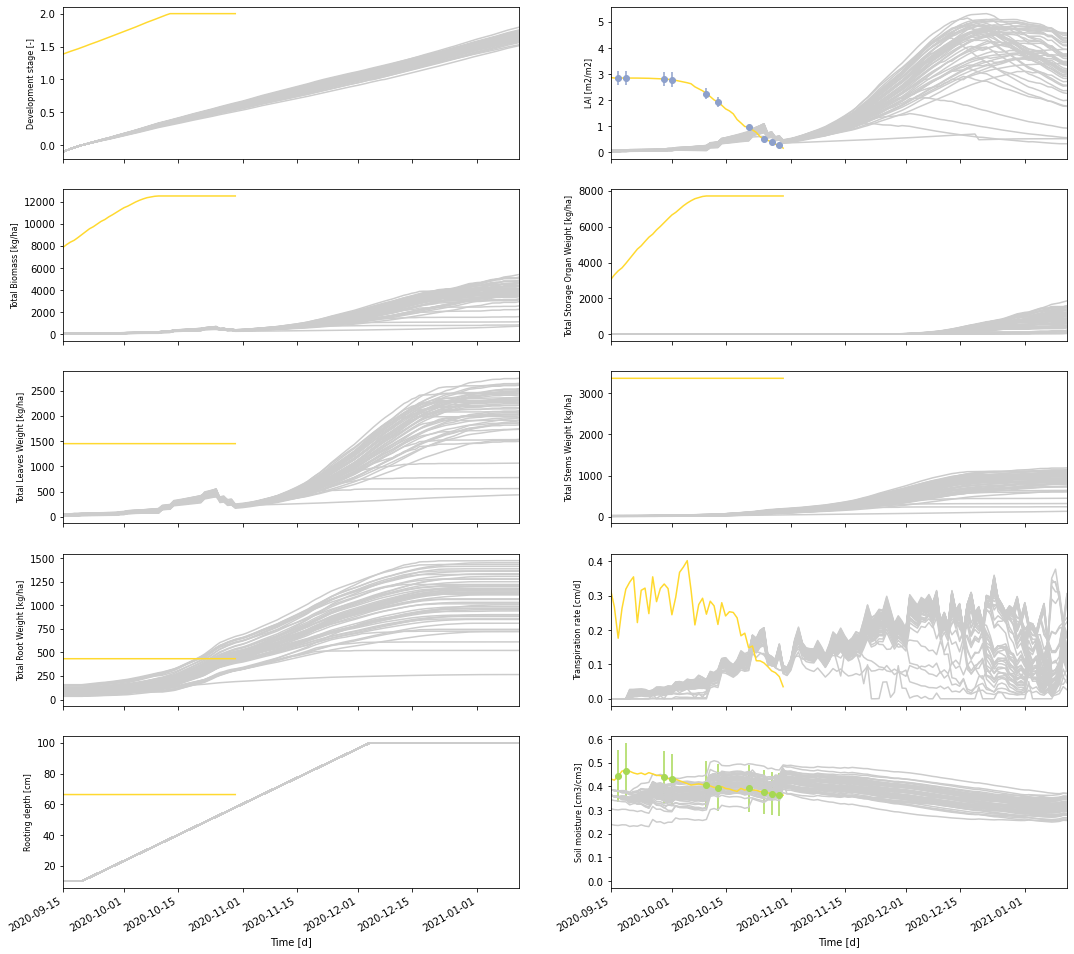

In [17]:
obs_period = dt.datetime(2020, 9, 15),dt.datetime(2021, 1, 12)
run_ensemble(50, obs_period)